In [75]:
from soam.workflow.time_series_extractor import TimeSeriesExtractor
from muttlib.dbconn import get_client
import pandas as pd
from soam.models.prophet import SkProphet

In [76]:
sqlite_cfg = {
    "db_type": "sqlite",
    "database": "soam_quickstart.db"
}

sqlite_client = get_client(sqlite_cfg)[1]

In [77]:
extractor = TimeSeriesExtractor(db=sqlite_client, table_name='stock')

In [78]:
query={
    'columns': '*',
    'extra_where_conditions': ["symbol = 'AAPL'"],
    'dimensions': ['date']
    
}
df = extractor.run(build_query_kwargs = query)
df.head()

,id,date,symbol,avg_num_trades,avg_price
0,1,2021-03-01,AAPL,80000.0,125.0
1,2,2021-03-02,AAPL,70000.0,126.0
2,3,2021-03-03,AAPL,80000.0,123.0
3,4,2021-03-04,AAPL,70000.0,121.0
4,5,2021-03-05,AAPL,80000.0,119.0


In [79]:
df = df[['date', 'avg_price']]
df.rename(columns = {
    'date': 'ds',
    'avg_price': 'y'}, inplace = True)

df.ds = pd.to_datetime(df.ds)

df.head()

,ds,y
0,2021-03-01,125.0
1,2021-03-02,126.0
2,2021-03-03,123.0
3,2021-03-04,121.0
4,2021-03-05,119.0


In [94]:
from soam.workflow import (
    Backtester,
    BaseDataFrameTransformer,
    Transformer
)
from sklearn.metrics import mean_absolute_error
from soam.models.prophet import SkProphet
from soam.workflow.forecaster import Forecaster
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from soam.constants import (
    ANOMALY_PLOT,
    DS_COL,
    FIG_SIZE,
    MONTHLY_TIME_GRANULARITY,
    PLOT_CONFIG,
    Y_COL,
)
from tests.helpers import sample_data_df

In [95]:
my_model = SkProphet()
forecaster = Forecaster(my_model)

In [96]:
class SimpleProcessor(BaseDataFrameTransformer):
    """Create a Simple Processor object."""

    def __init__(self, **fit_params):  # pylint:disable=super-init-not-called
        self.preproc = StandardScaler(**fit_params)

    def fit(self, df_X):
        self.preproc.fit(df_X[Y_COL].values.reshape(-1, 1))
        return self

    def transform(self, df_X, inplace=True):
        if not inplace:
            df_X = df_X.copy()
        df_X[Y_COL] = self.preproc.transform(df_X[Y_COL].values.reshape(-1, 1)) + 10
        return df_X

In [108]:
from soam.plotting.forecast_plotter import ForecastPlotterTask
from pathlib import Path

In [128]:
plot_config = deepcopy(PLOT_CONFIG)
plot_config['anomaly_plot']['title'] = 'Performance for {metric_name} {start_date:%d-%b} to {end_date:%d-%b}'
forecast_plotter = ForecastPlotterTask(
    path=Path('img/backtester_example'),
    metric_name='MAE',
    time_granularity='D',
    plot_config=plot_config,
)

In [131]:
len(df)

22

In [141]:
backtester = Backtester(forecaster=forecaster,
                        preprocessor=Transformer(SimpleProcessor()),
                        #forecast_plotter=forecast_plotter,
                        train_window=7,
                        test_window=1,
                        metrics={'mae': mean_absolute_error})

results = backtester.run(time_series=df)

/tmp/ipykernel_10148/287151404.py:1: UserWarning: A Task was passed as an argument to Backtester, you likely want to first initialize Backtester with any static (non-Task) arguments, then call the initialized task with any dynamic (Task) arguments instead. For example:

  my_task = Backtester(...)  # static (non-Task) args go here
  res = my_task(...)  # dynamic (Task) args go here

see https://docs.prefect.io/core/concepts/flows.html#apis for more info.
  backtester = Backtester(forecaster=forecaster,
/tmp/ipykernel_10148/1154949361.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X[Y_COL] = self.preproc.transform(df_X[Y_COL].values.reshape(-1, 1)) + 10
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True 

In [148]:
perf = []
for i in range(len(results)):
    perf.append(results[i]['metrics']['mae'])

In [152]:
perf=perf[0:14]

SyntaxError: unexpected EOF while parsing (475383847.py, line 1)

Text(0.5, 1.0, 'MAE')

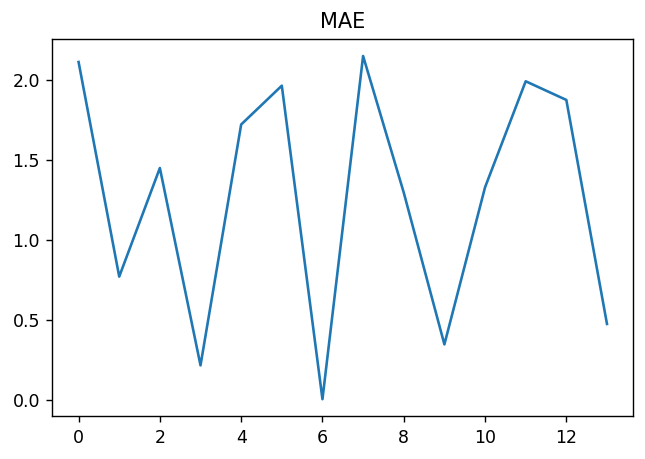

In [158]:
import matplotlib.pyplot as plt
plt.figure(dpi=125)
plt.plot(perf)

plt.title('MAE')